In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from pathlib import Path
import os
import cv2
from torch.utils.data import DataLoader, Dataset
import random
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms

In [9]:
base_path = os.getcwd()
data_path = os.path.join(base_path, 'Massachusetts_roads_dataset', 'tiff')
train_data_path = os.path.join(data_path, 'train')
train_labels_path = os.path.join(data_path, 'train_labels')
test_data_path = os.path.join(data_path, 'test')
test_labels_path = os.path.join(data_path, 'test_labels')
val_data_path = os.path.join(data_path, 'val')
val_labels_path = os.path.join(data_path, 'val_labels')

train_data = glob(f'{train_data_path}\\*tiff')
test_data = glob(f'{test_data_path}\\*tiff')
val_data = glob(f'{val_data_path}\\*tiff')

train_label_data = glob(f'{train_labels_path}\\*tif')
test_label_data = glob(f'{test_labels_path}\\*tif')
val_label_data = glob(f'{val_labels_path}\\*tif')

data = train_data + test_data + val_data
labels = train_label_data + test_label_data + val_label_data

data = {'data_path': data, 'label_path': labels}
data = pd.DataFrame(data)

In [10]:
data = data.iloc[:100, :]

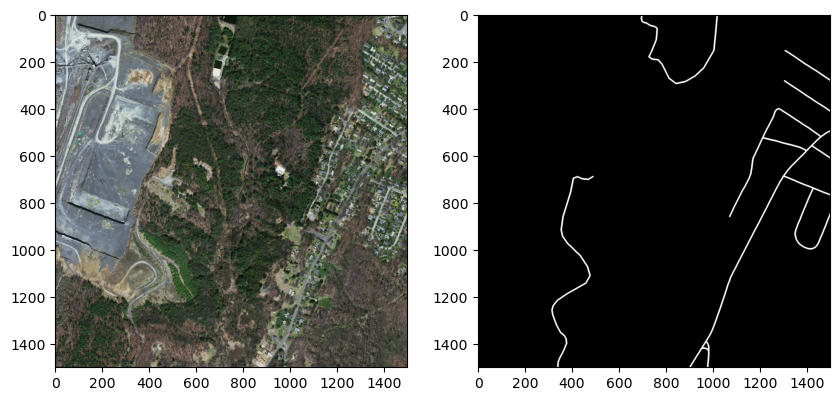

In [14]:
i = random.randint(0, len(data)-1)
#row = data.iloc[i]
img = cv2.cvtColor(cv2.imread(data.data_path[i]), cv2.COLOR_BGR2RGB)
label = cv2.cvtColor(cv2.imread(data.label_path[i]), cv2.COLOR_BGR2GRAY)

i, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,15))

ax1.imshow(img)

ax2.imshow(label, cmap='gray')

In [15]:
train, test = train_test_split(data, random_state=42, shuffle=True, test_size=0.15)

In [16]:
class Custom_dataset(Dataset):
    def __init__(self,data, augmentation=False) -> None:

        self.data = data
        self.augmentation = augmentation

    def __len__(self):

        return len(self.data)
    
    def __getitem__(self, index):

        img = cv2.cvtColor(cv2.imread(data.data_path[index]), cv2.COLOR_BGR2RGB)
        label = cv2.cvtColor(cv2.imread(data.label_path[index]), cv2.COLOR_BGR2GRAY)
        label = np.expand_dims(label, axis=-1)

        if self.augmentation == True:
            pass

        image = torch.tensor(img, dtype=torch.float32).permute(2,0,1)/255
        label = torch.tensor(label, dtype=torch.float32).permute(2,0,1)/255


        return image, label
        


In [17]:
train = Custom_dataset(train)
test = Custom_dataset(test)
batch_size=2
train_loaded = DataLoader(train, batch_size, shuffle=True)
test_loaded = DataLoader(test, batch_size, shuffle=False)

In [18]:
def plot_image(data:DataLoader):
    '''
    Both X and y should be a image like in a segmentation task
    imput: Takes in a Pytorch Dataloader and plot the train image and label image
    '''
    video, label = next(iter(train_loaded))
    video.shape, label.shape
    i, (ax1, ax2) = plt.subplots(1,2, figsize=(10,15))
    ax1.imshow(video.permute(0,2,3,1)[0]), ax2.imshow(label.permute(0,2,3,1)[0])

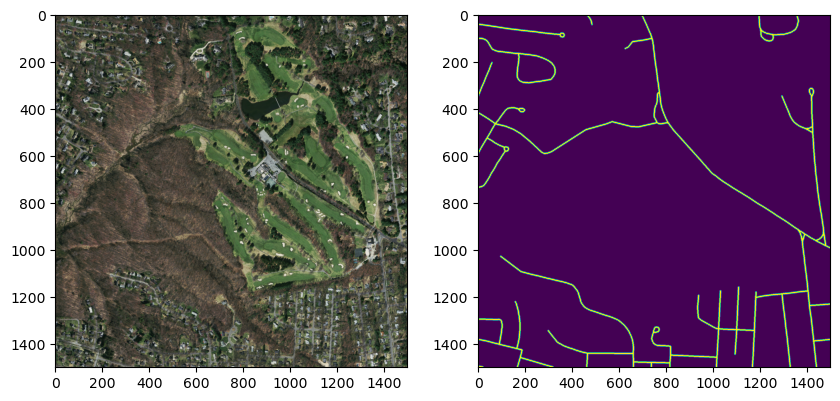

In [20]:
plot_image(train_loaded)

In [21]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=True, out_sz=(1500,1500)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.out_sz = out_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = torch.nn.functional.interpolate(out, self.out_sz)
        return out

In [28]:
model = UNet().to(device)
model

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      )
      (4): Block(
        (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    

In [25]:
def lr_scheduler(lr):
    if epochs < 10:
        return lr
    else:
        return np.exp(-1)*lr
    

epochs = 50
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters(), lr=lr_scheduler(0.01))


In [29]:
import time, tqdm

train_loss = []
test_loss = []
starttime = time.time()

for x in tqdm.tqdm(range(0,epochs)):

    model.train()

    train_loss = 0
    test_loss = 0

    for (i, (X,y)) in enumerate(train_loaded):

        (X,y) = (X.to(device), y.to(device))

        pred = model(X)
        loss = loss_fn(pred, y)
        optim.zero_grad
        loss.backward()
        optim.step()

        train_loss += loss

        torch.save(model.state_dict(), 'Massachusetts_roads_dataset/model.pth')
    
    with torch.inference_mode():
        model.eval()

        for (X,y) in test_loaded:

            (X,y) = (X.to(device), y.to(device))

            pred = model(X)
            test_loss += loss_fn(pred, y)

    AvgTrainLoss = train_loss / (len(train_loaded/batch_size))
    AvgTestLoss = test_loss / (len(test_loaded/batch_size))

    train.loss.append(AvgTrainLoss.cpu().detach().numpy())
    test_loss.append(AvgTestLoss.cpu().detach().numpy())

    print(f'EPOCH : {i+1}')
    print(f'train_loss: {AvgTrainLoss} | test_loss: {AvgTestLoss}')


endTime = time.time()
print(f'total time for training: {endTime-starttime}')

  0%|          | 0/50 [00:23<?, ?it/s]


RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 1784217600 bytes.